In [1]:
from sqlalchemy import create_engine, event
import urllib.parse

import pandas as pd
import datetime as dt
import numpy as np
import time
import matplotlib.pylab as plt

# Input & Output

In [2]:
# SQL database
server = 'CSKMA0400\RDB_Data'
db = 'JLDJobPath'
odbc_connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+db+';Trusted_Connection=yes'

sql_tables = [
#               'linkedclaims_casuals_2018m04_v2_flat_20140101_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
              'linkedclaims_casuals_2018m04_v2_flat_20140401_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
              'linkedclaims_casuals_2018m04_v2_flat_20140701_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
              'linkedclaims_casuals_2018m04_v2_flat_20141001_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
              'linkedclaims_casuals_2018m04_v2_flat_20150101_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
              'linkedclaims_casuals_2018m04_v2_flat_20150401_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
              'linkedclaims_casuals_2018m04_v2_flat_20150701_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
              'linkedclaims_casuals_2018m04_v2_flat_20151001_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
#               'linkedclaims_casuals_2018m04_v2_flat_20160101_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
#               'linkedclaims_casuals_2018m04_v2_flat_20160401_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
#               'linkedclaims_casuals_2018m04_v2_flat_20160701_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld',
#               'linkedclaims_casuals_2018m04_v2_flat_20161001_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld'
             ]

clustering_time_labels = [
#                           '20140101', 
                          '20140401', 
                          '20140701', 
                          '20141001', 
                          '20150101', 
                          '20150401', 
                          '20150701', 
                          '20151001', 
#                           '20160101', 
#                           '20160401', 
#                           '20160701', 
#                           '20161001'
                         ]
outcome_time_labels = [
#                        '20160901', 
                       '20161201', 
                       '20170301', 
                       '20170601', 
                       '20170901', 
                       '20171201', 
                       '20180301', 
                       '20180601', 
#                        '20180901', 
#                        '20181201', 
#                        '20190301', 
#                        '20190601'
                      ]

outcome_var = 'detailed_outcome_32m'
outcome_targets = ['On Live Register (excluding casual workers) - JA', 'On Live Register (excluding casual workers) - JB']

cluster_var = 'cluster'
cluster_targets = [0,1,2,3,4,5,6]

eligible_var ='JP Eligible'
eligible_target_var = 'duration_days_0'
eligible_target_var_min_val = 11*30

jp_flag_in_aw_var = 'jp_flag_in_aw'
cancelled_flag_in_aw_var = 'cancelled_flag_in_aw'
paused_flag_in_aw_var = 'paused_flag_in_aw'
jobpath_flag_after_aw_var = 'jp_flag_after_aw'

age1_var = 'Over 50'
age1_target_var = 'age'
age1_target_var_min_val = 50
age1_target_var_max_val = 99

figsize = 10

export_raw_data=True
path = '//cskma0294/F/Evaluations/JobPath/Python/Analysis/JPOutcomes/'
csvfilename = 'raw_data_'+outcome_var+'.csv'

# Procedure

In [3]:
def read_data_from_sql(sql_table):
    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection

    @event.listens_for(engine, 'before_cursor_execute')
    def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
        if executemany:
            cursor.fast_executemany = True

    df = pd.read_sql_table(sql_table, engine)
    conn.close()
    return df

res_data = pd.DataFrame()
for t in sql_tables:

    print ('Read Data fromn \n\t %s' %(t))
    data = read_data_from_sql(t)
    
    print ('Summarizing')
    data [eligible_var] = 0
    data.loc[data[eligible_target_var] >= eligible_target_var_min_val, eligible_var] = 1
    
    data [age1_var] = 0
    data.loc[(data[age1_target_var] > age1_target_var_min_val) &
             (data[age1_target_var] < age1_target_var_max_val), 
             age1_var] = 1
    
    res_outcome = pd.crosstab(index=data[outcome_var],
                              columns=data[cluster_var],
                              normalize="columns")
    
    res_eligible = pd.crosstab(index=data[eligible_var],
                              columns=data[cluster_var],
                              normalize="columns")
    
    ##
    data_eligible_jpaw = data.loc[(data[eligible_var] == 1) & 
                                  (data[jp_flag_in_aw_var]  == 1) &
                                  (data[cancelled_flag_in_aw_var]  == 0) & 
                                  (data[paused_flag_in_aw_var] == 0) &
                                  (data[jobpath_flag_after_aw_var] == 0)]
    
    res_eligible_jpaw_outcome = pd.crosstab(index=data_eligible_jpaw[outcome_var],
                                            columns=data_eligible_jpaw[cluster_var],
                                            normalize="columns")
    
    ##
    data_eligible_nojpaw = data.loc[(data[eligible_var] == 1) & 
                                    (data[jp_flag_in_aw_var]  == 0) &
                                    (data[jobpath_flag_after_aw_var] == 0)]
    
    res_eligible_nojpaw_outcome = pd.crosstab(index=data_eligible_nojpaw[outcome_var],
                                              columns=data_eligible_nojpaw[cluster_var],
                                              normalize="columns")
    
    ##
    data_elegible_jpaw_age1 = data.loc[(data[eligible_var] == 1) & 
                                       (data[age1_var] == 1) & 
                                       (data[jp_flag_in_aw_var]  == 1) &
                                       (data[cancelled_flag_in_aw_var]  == 0) & 
                                       (data[paused_flag_in_aw_var] == 0) &
                                       (data[jobpath_flag_after_aw_var] == 0)]
    
    res_eligible_jpaw_age1_outcome = pd.crosstab(index=data_elegible_jpaw_age1[outcome_var],
                                                 columns=data_elegible_jpaw_age1[cluster_var],
                                                 normalize="columns")
    
    ##
    data_elegible_nojpaw_age1 = data.loc[(data[eligible_var] == 1) & 
                                         (data[jp_flag_in_aw_var]  == 0)& 
                                         (data[age1_var] == 1) &
                                         (data[jobpath_flag_after_aw_var] == 0)]
    
    res_eligible_nojpaw_age1_outcome = pd.crosstab(index=data_elegible_nojpaw_age1[outcome_var],
                                                   columns=data_elegible_nojpaw_age1[cluster_var],
                                                   normalize="columns")
    
    mydict={}
    for ct in cluster_targets:
        mydict [eligible_var+str(ct)] = res_eligible[ct][1]
        
        for ot in outcome_targets:
            try:
                mydict [ot+str(ct)] = res_outcome[ct][ot]
            except:
                mydict [ot+str(ct)] = 0
            try:
                mydict [ot+'el_nojpaw'+str(ct)] = res_eligible_nojpaw_outcome[ct][ot]
            except:
                mydict [ot+'el_nojpaw'+str(ct)] = 0
            try:
                mydict [ot+'el_jpaw'+str(ct)] = res_eligible_jpaw_outcome[ct][ot]
            except:
                mydict [ot+'el_jpaw'+str(ct)] = 0
            try:
                mydict [ot+'el_jpaw'+age1_var+str(ct)] = res_eligible_jpaw_age1_outcome [ct][ot]
            except:
                mydict [ot+'el_jpaw'+age1_var+str(ct)] = 0
            try:
                mydict [ot+'el_nojpaw'+age1_var+str(ct)] = res_eligible_nojpaw_age1_outcome [ct][ot]
            except:
                mydict [ot+'el_nojpaw'+age1_var+str(ct)] = 0
                
                
            
            
        
    res_data = res_data.append(mydict, ignore_index=True)


Read Data fromn 
	 linkedclaims_casuals_2018m04_v2_flat_20140401_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld
Summarizing
Read Data fromn 
	 linkedclaims_casuals_2018m04_v2_flat_20140701_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld
Summarizing
Read Data fromn 
	 linkedclaims_casuals_2018m04_v2_flat_20141001_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld
Summarizing
Read Data fromn 
	 linkedclaims_casuals_2018m04_v2_flat_20150101_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld
Summarizing
Read Data fromn 
	 linkedclaims_casuals_2018m04_v2_flat_20150401_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld
Summarizing
Read Data fromn 
	 linkedclaims_casuals_2018m04_v2_flat_20150701_with_income_36Vars__7BGM_full_clusters_jp_summary_with_outcomes_edu_selected_jld
Summarizing
Read Data fromn 
	 linkedclaims_casuals_2018m04_v2_f

# Timeseries: Outcome by cluster

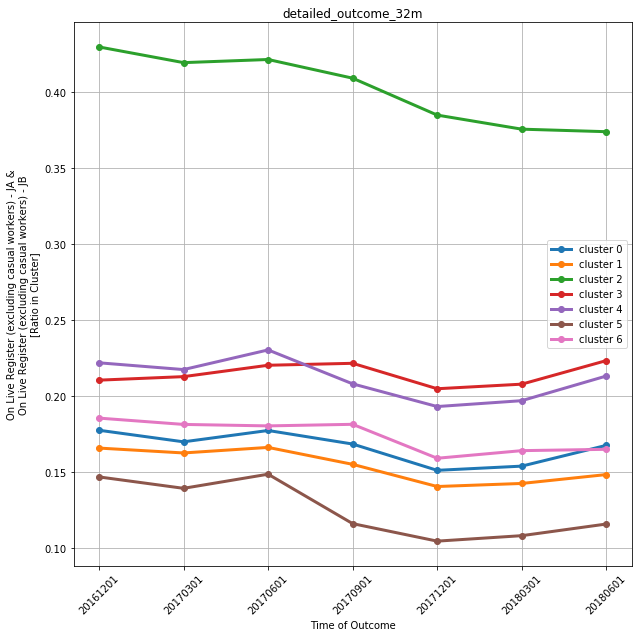

In [4]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data = res_data[outcome_targets[0]+str(ct)] + res_data[outcome_targets[1]+str(ct)]
    plt.plot(plot_data, label= 'cluster ' + str(ct), linewidth=3, marker='o')
plt.title(outcome_var)
plt.xticks(np.arange(len(outcome_time_labels)),outcome_time_labels, rotation = 45)
plt.xlabel('Time of Outcome')
plt.ylabel((' &\n'.join(outcome_targets) + '\n[Ratio in Cluster]'))
plt.grid()
plt.legend()

# Timeseries: JP Elegible by Cluster

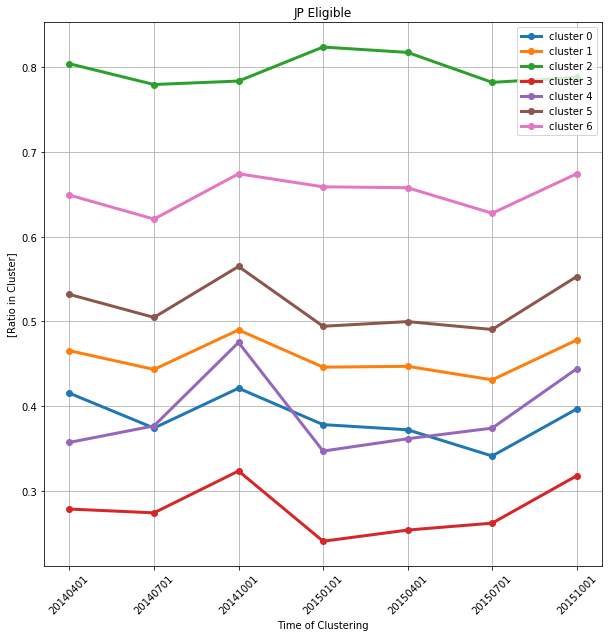

In [5]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data = res_data[eligible_var+str(ct)]
    plt.plot(plot_data, label= 'cluster ' + str(ct), linewidth=3, marker='o')
plt.title(eligible_var)
plt.xticks(np.arange(len(clustering_time_labels)), clustering_time_labels, rotation = 45)
plt.xlabel('Time of Clustering')
plt.ylabel('[Ratio in Cluster]')
plt.grid()
plt.legend()

# Timeseries: Outcome For Population Elegible and in JP in AW by cluster

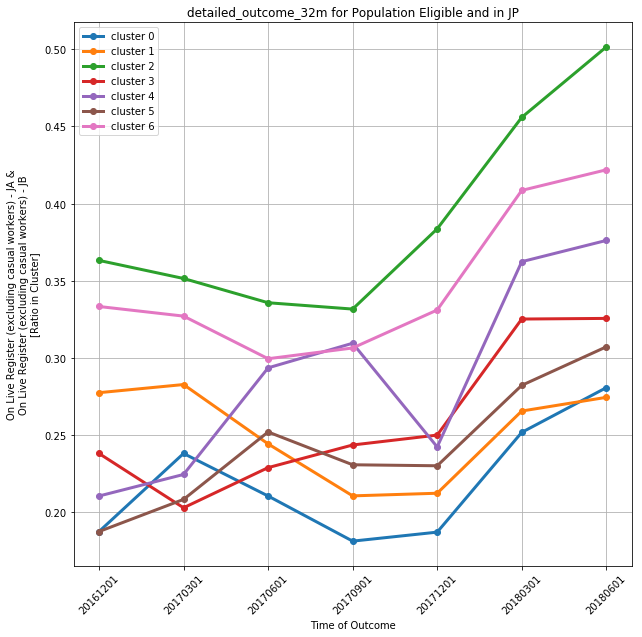

In [6]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data = res_data[outcome_targets[0]+'el_jpaw'+str(ct)] + res_data[outcome_targets[1]+'el_jpaw'+str(ct)]
    plt.plot(plot_data, label= 'cluster ' + str(ct), linewidth=3, marker='o')
plt.title(outcome_var + ' for Population Eligible and in JP')
plt.xticks(np.arange(len(outcome_time_labels)),outcome_time_labels, rotation = 45)
plt.xlabel('Time of Outcome')
plt.ylabel((' &\n'.join(outcome_targets) + '\n[Ratio in Cluster]'))
plt.grid()
plt.legend()

# Timeseries: Outcome For Population Elegible and NOT in JP in AW by cluster

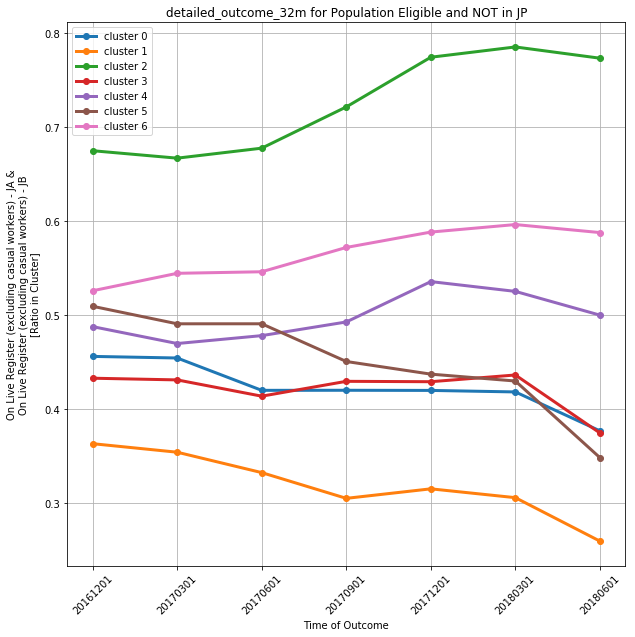

In [7]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data = res_data[outcome_targets[0]+'el_nojpaw'+str(ct)] + res_data[outcome_targets[1]+'el_nojpaw'+str(ct)]
    plt.plot(plot_data, label= 'cluster ' + str(ct), linewidth=3, marker='o')
plt.title(outcome_var + ' for Population Eligible and NOT in JP')
plt.xticks(np.arange(len(outcome_time_labels)),outcome_time_labels, rotation = 45)
plt.xlabel('Time of Outcome')
plt.ylabel((' &\n'.join(outcome_targets) + '\n[Ratio in Cluster]'))
plt.grid()
plt.legend()

# Timeseries: Outcome  Population Eligible and in JP / Population Eligible and NOT in JP by cluster

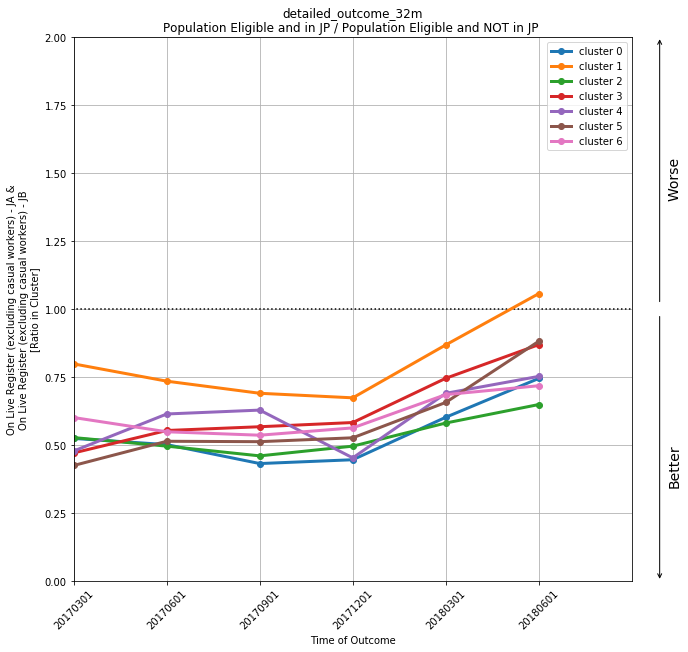

In [8]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data_el_jpaw = res_data[outcome_targets[0]+'el_jpaw'+str(ct)] + res_data[outcome_targets[1]+'el_jpaw'+str(ct)]
    plot_data_el_nojpaw = res_data[outcome_targets[0]+'el_nojpaw'+str(ct)] + res_data[outcome_targets[1]+'el_nojpaw'+str(ct)]
    plot_data = plot_data_el_jpaw/plot_data_el_nojpaw
    
    plt.plot(plot_data, label= 'cluster ' + str(ct) , linewidth=3, marker='o')
plt.title(outcome_var + '\nPopulation Eligible and in JP / Population Eligible and NOT in JP ')
plt.xticks(np.arange(len(outcome_time_labels)),outcome_time_labels, rotation = 45)
plt.xlabel('Time of Outcome')
plt.ylabel((' &\n'.join(outcome_targets) + '\n[Ratio in Cluster]'))

plt.xlim(1,7)
plt.ylim(0, 2)
plt.hlines(1,xmin=0, xmax=11, colors='k', linestyles='dotted')

plt.gcf().text(0.95, 0.70, 'Worse', fontsize=14, rotation = 90)
plt.annotate('', xy=(1.05, 0.51), xycoords='axes fraction', xytext=(1.05, 1), arrowprops=dict(arrowstyle="<-", color='k'))

plt.gcf().text(0.95, 0.30, 'Better', fontsize=14, rotation = 90)
plt.annotate('', xy=(1.05, 0.49), xycoords='axes fraction', xytext=(1.05, 0), arrowprops=dict(arrowstyle="<-", color='k'))

plt.grid()
plt.legend()

# Timeseries: Outcome For Population Elegible, in JP in AW, Over 50 by cluster

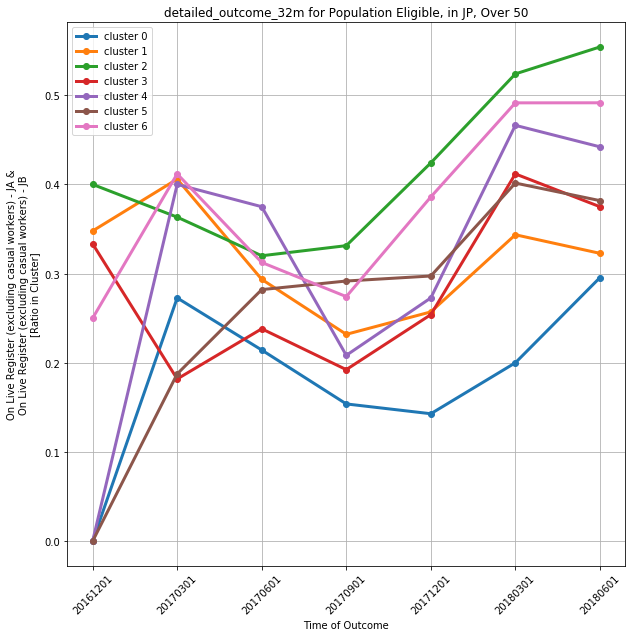

In [9]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data = res_data[outcome_targets[0]+'el_jpaw'+age1_var+str(ct)] + res_data[outcome_targets[1]+'el_jpaw'+age1_var+str(ct)]
    plt.plot(plot_data, label= 'cluster ' + str(ct), linewidth=3, marker='o')
plt.title(outcome_var + ' for Population Eligible, in JP, '+ age1_var)
plt.xticks(np.arange(len(outcome_time_labels)),outcome_time_labels, rotation = 45)
plt.xlabel('Time of Outcome')
plt.ylabel((' &\n'.join(outcome_targets) + '\n[Ratio in Cluster]'))
plt.grid()
plt.legend()

# Timeseries: Outcome For Population Elegible, NOT in JP in AW, Over 50 by cluster

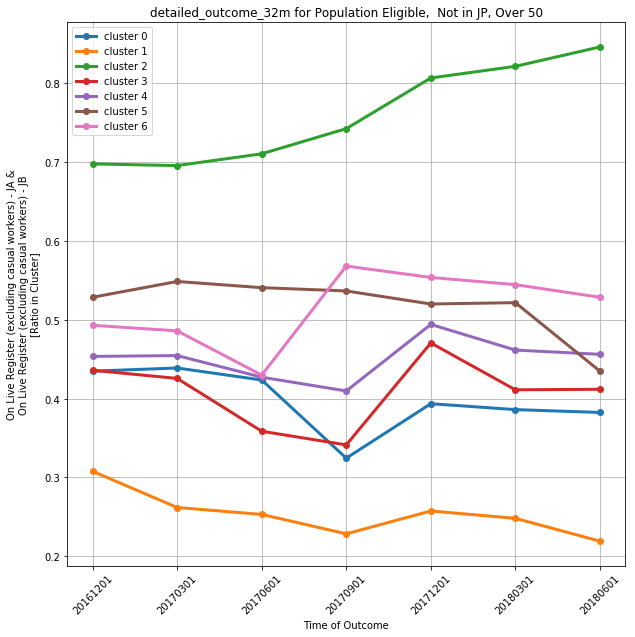

In [10]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data = res_data[outcome_targets[0]+'el_nojpaw'+age1_var+str(ct)] + res_data[outcome_targets[1]+'el_nojpaw'+age1_var+str(ct)]
    plt.plot(plot_data, label= 'cluster ' + str(ct), linewidth=3, marker='o')
plt.title(outcome_var + ' for Population Eligible,  Not in JP, ' + age1_var)
plt.xticks(np.arange(len(outcome_time_labels)),outcome_time_labels, rotation = 45)
plt.xlabel('Time of Outcome')
plt.ylabel((' &\n'.join(outcome_targets) + '\n[Ratio in Cluster]'))
plt.grid()
plt.legend()

# Timeseries: Outcome  Population Eligible, in JP, Over 50 / Population Eligible, NOT in JP, Over 50 by cluster

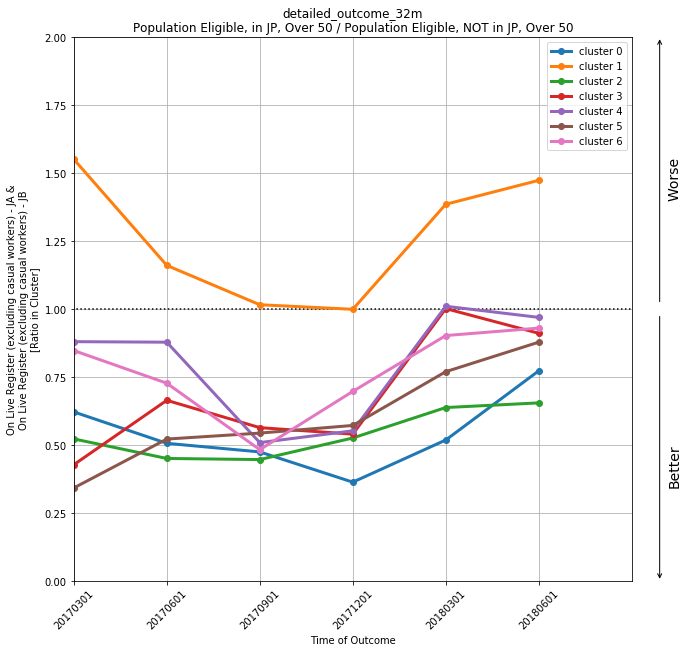

In [11]:
fig = plt.figure(1, figsize=(figsize,figsize))

# myax = res_data[outcome_targets[0]+str(cluster_targets[0])].plot()
for ct in cluster_targets:
    plot_data_el_jpaw = res_data[outcome_targets[0]+'el_jpaw'+age1_var+str(ct)] + res_data[outcome_targets[1]+'el_jpaw'+age1_var+str(ct)]
    plot_data_el_nojpaw = res_data[outcome_targets[0]+'el_nojpaw'+age1_var+str(ct)] + res_data[outcome_targets[1]+'el_nojpaw'+age1_var+str(ct)]
    plot_data = plot_data_el_jpaw/plot_data_el_nojpaw
    
    plt.plot(plot_data, label= 'cluster ' + str(ct), linewidth=3, marker='o')
plt.title(outcome_var + '\nPopulation Eligible, in JP, '+ age1_var +' / Population Eligible, NOT in JP, ' + age1_var)
plt.xticks(np.arange(len(outcome_time_labels)),outcome_time_labels, rotation = 45)
plt.xlabel('Time of Outcome')
plt.ylabel((' &\n'.join(outcome_targets) + '\n[Ratio in Cluster]'))

plt.xlim(1,7)
plt.ylim(0, 2)
plt.hlines(1,xmin=0, xmax=11, colors='k', linestyles='dotted')

plt.gcf().text(0.95, 0.70, 'Worse', fontsize=14, rotation = 90)
plt.annotate('', xy=(1.05, 0.51), xycoords='axes fraction', xytext=(1.05, 1), arrowprops=dict(arrowstyle="<-", color='k'))

plt.gcf().text(0.95, 0.30, 'Better', fontsize=14, rotation = 90)
plt.annotate('', xy=(1.05, 0.49), xycoords='axes fraction', xytext=(1.05, 0), arrowprops=dict(arrowstyle="<-", color='k'))

plt.grid()
plt.legend()

# Export Raw Data

In [12]:
if export_raw_data:
    print ('Writing raw data in: \n%s' %(path+csvfilename))
    res_data.to_csv(path+csvfilename, index=False)
    
print ('ALL DONE')

Writing raw data in: 
//cskma0294/F/Evaluations/JobPath/Python/Analysis/JPOutcomes/raw_data_detailed_outcome_32m.csv
ALL DONE
